In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score
import shap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV, cross_val_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.multioutput import MultiOutputRegressor
import json


c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
def get_api_key():
    try:
        with open("config.json", "r") as file:
            config = json.load(file)
            return config["api_key"]  
    except FileNotFoundError:
        raise FileNotFoundError("API key file 'config.json' not found. Ensure it exists and is not uploaded to version control.")
    except KeyError:
        raise KeyError("API key is missing or incorrectly named in the 'config.json' file.")

api_key = get_api_key()

fred = Fred(api_key=api_key)


gdp_data = fred.get_series('A939RX0Q048SBEA')        # Real Gross Domestic Product per capita
cpi_data = fred.get_series('CPIAUCSL')               # Consumer Price Index
unemployment_data = fred.get_series('UNRATE')        # Unemployment Rate
interest_rate_data = fred.get_series('FEDFUNDS')     # Interest Rate
poverty_rate_data = fred.get_series('PPAAUS00000A156NCEN')       # Poverty Rate
inflation_data = fred.get_series('T10YIE')       # inflation Rate

df = pd.DataFrame({
    'gdp_per_capita': gdp_data,
    'cpi': cpi_data,
    'unemployment': unemployment_data,
    'interest_rate': interest_rate_data,
    'poverty_rate': poverty_rate_data,
    'inflation': inflation_data
})

df.reset_index(inplace=True)
df.columns = ['date', 'gdp', 'cpi', 'unemployment', 'interest_rate','poverty_rate','inflation']
df.interpolate(method="linear", inplace=True)
df.dropna(inplace=True)

print(df.tail())

df['date'] = pd.to_datetime(df['date'])
#df.set_index('date', inplace=True)


           date      gdp      cpi  unemployment  interest_rate  poverty_rate  \
6466 2024-12-04  69359.0  316.441           4.2           4.64          12.6   
6467 2024-12-05  69359.0  316.441           4.2           4.64          12.6   
6468 2024-12-06  69359.0  316.441           4.2           4.64          12.6   
6469 2024-12-09  69359.0  316.441           4.2           4.64          12.6   
6470 2024-12-10  69359.0  316.441           4.2           4.64          12.6   

      inflation  
6466       2.29  
6467       2.25  
6468       2.24  
6469       2.27  
6470       2.29  


In [3]:
summary_stats = df.describe()
print(summary_stats)



                gdp          cpi  unemployment  interest_rate  poverty_rate  \
count   5798.000000  5798.000000   5798.000000    5798.000000   5798.000000   
mean   58450.069076   237.248723      5.813660       1.644585     13.673413   
std     5000.822478    34.569835      2.019450       1.857023      1.238634   
min    50467.060606   182.643478      3.400000       0.050000     11.900000   
25%    54545.113636   212.712557      4.235611       0.130000     12.600000   
50%    56563.447761   234.887201      5.140020       0.991801     13.220755   
75%    61909.149254   255.486464      7.001087       2.420000     14.750755   
max    69359.000000   316.441000     14.800000       5.330000     15.900000   

         inflation  
count  5798.000000  
mean      2.090306  
std       0.402222  
min       0.040000  
25%       1.840000  
50%       2.190000  
75%       2.360000  
max       3.020000  


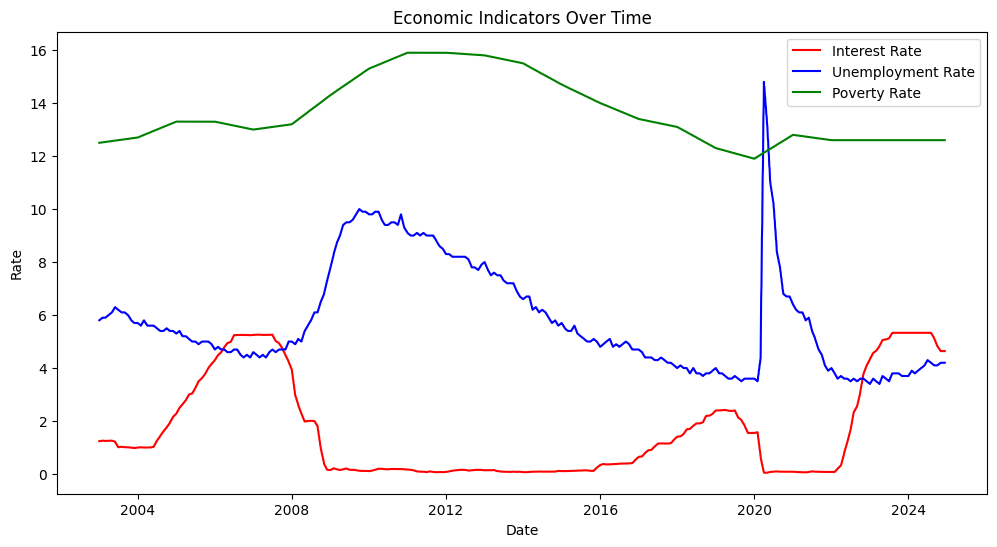

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['interest_rate'], label='Interest Rate', color='red')
plt.plot(df.index, df['unemployment'], label='Unemployment Rate', color='blue')
plt.plot(df.index, df['poverty_rate'], label='Poverty Rate', color='green')
plt.legend()
plt.title("Economic Indicators Over Time")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()


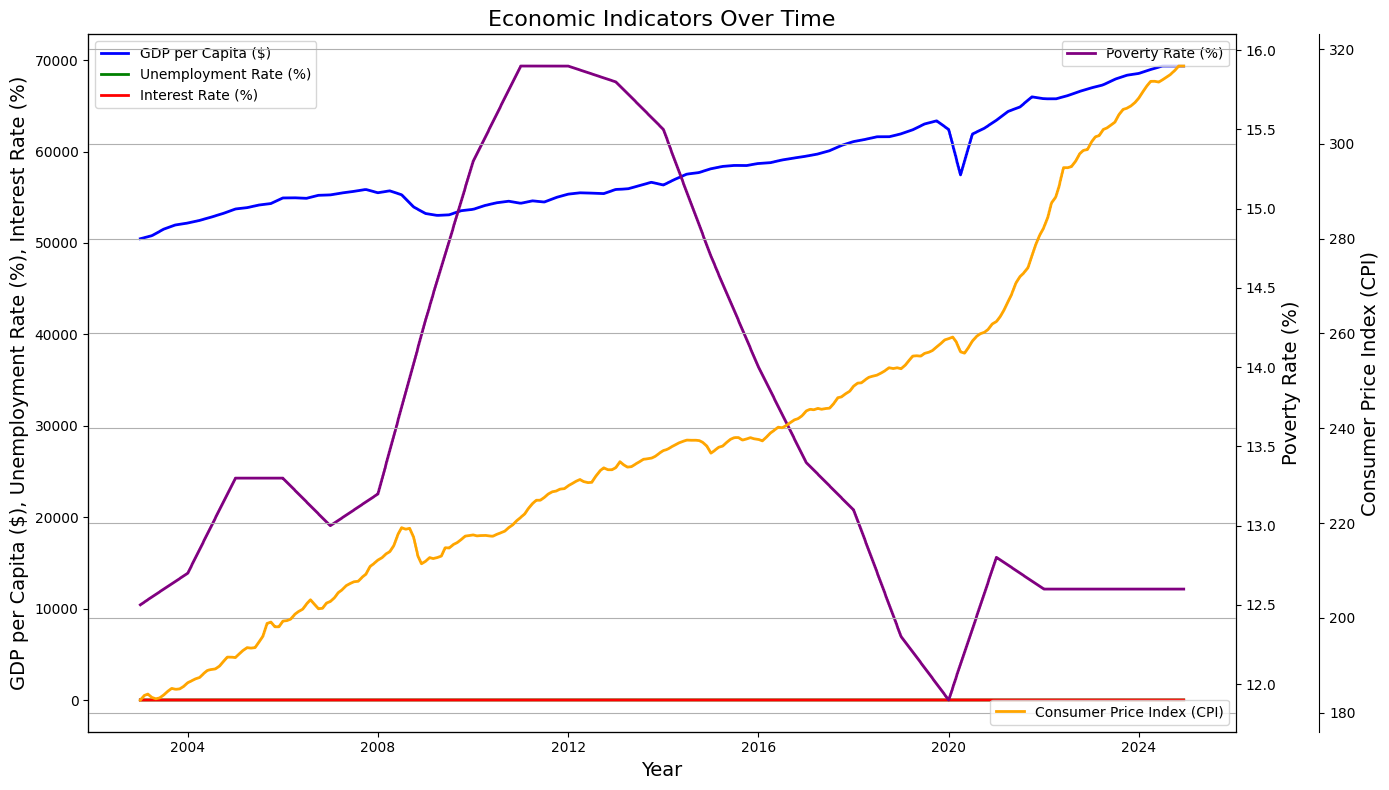

In [5]:
fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('GDP per Capita ($), Unemployment Rate (%), Interest Rate (%)', fontsize=14)
ax1.plot(df.index, df['gdp'], label='GDP per Capita ($)', color='blue', linewidth=2)
ax1.plot(df.index, df['unemployment'], label='Unemployment Rate (%)', color='green', linewidth=2)
ax1.plot(df.index, df['interest_rate'], label='Interest Rate (%)', color='red', linewidth=2)
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
ax2.set_ylabel('Poverty Rate (%)', fontsize=14)
ax2.plot(df.index, df['poverty_rate'], label='Poverty Rate (%)', color='purple', linewidth=2)
ax2.tick_params(axis='y', labelcolor='black')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.set_ylabel('Consumer Price Index (CPI)', fontsize=14)
ax3.plot(df.index, df['cpi'], label='Consumer Price Index (CPI)', color='orange', linewidth=2)
ax3.tick_params(axis='y', labelcolor='black')

plt.title('Economic Indicators Over Time', fontsize=16)
fig.tight_layout() 

ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax3.legend(loc='lower right', bbox_to_anchor=(1, 0))

plt.grid(True)

plt.show()


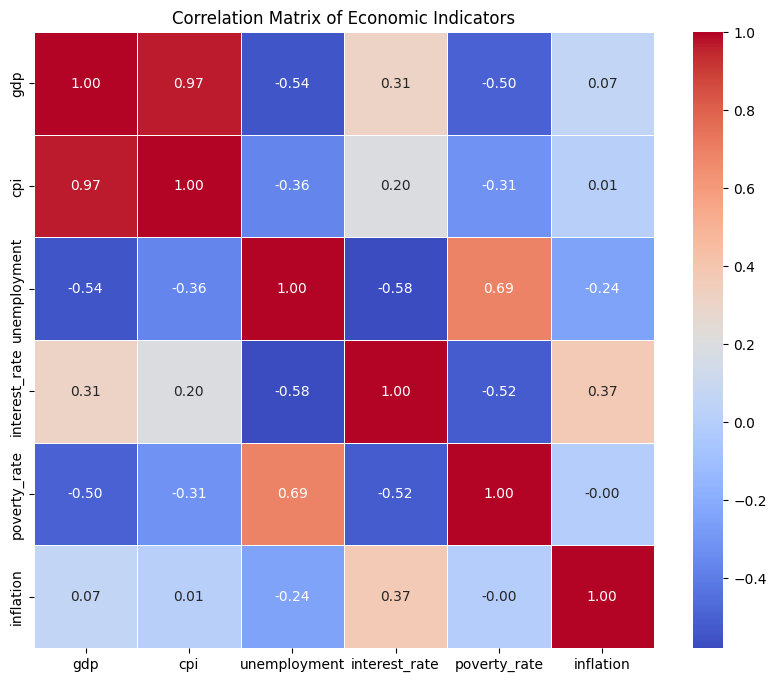

In [6]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Economic Indicators')
plt.show()

In [7]:
df['gdp_change'] = df['gdp'].pct_change()
df['cpi_change'] = df['cpi'].pct_change()
df['unemployment_diff'] = df['unemployment'].diff()
df['interest_rate_diff'] = df['interest_rate'].diff()
df['poverty_rate_diff'] = df['poverty_rate'].diff()

df.dropna(inplace=True)

X = df[['gdp_change', 'cpi_change', 'unemployment_diff', 'interest_rate_diff', 'poverty_rate_diff']]
y = df['unemployment'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Support Vector Regression": SVR(kernel='rbf', C=1.0, epsilon=0.2)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} - Mean Squared Error: {mse}")

Linear Regression - Mean Squared Error: 2.688325179038311
Decision Tree - Mean Squared Error: 0.001091017392883027
Random Forest - Mean Squared Error: 0.0003370901997548909
Support Vector Regression - Mean Squared Error: 1.581022096630762


 98%|===================| 1134/1160 [00:22<00:00]        

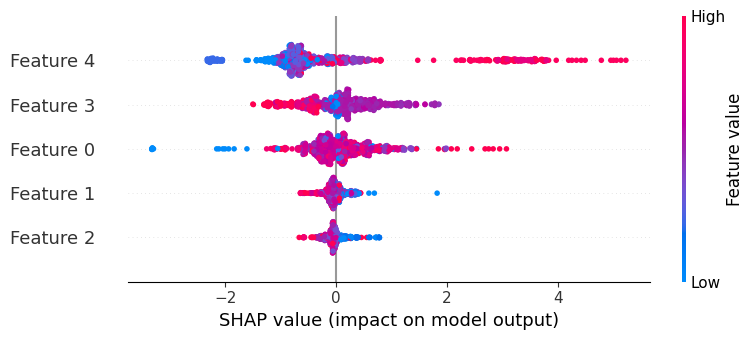

In [9]:
assert X_train_scaled.shape[1] == X_test_scaled.shape[1], "Mismatch in feature dimensions!"

explainer = shap.Explainer(models["Random Forest"], X_train_scaled)

shap_values = explainer(X_test_scaled, check_additivity=False)

shap.summary_plot(shap_values, X_test_scaled)


In [10]:
targets = ['cpi', 'unemployment', 'poverty_rate', 'gdp', 'inflation']  

X = df.drop(columns=targets).values  # No need to drop 'date' since it's already the index
y = {target: df[target].values for target in targets}  # Create a dictionary of target arrays

splits = {}
for target in targets:
    X_train, X_test, y_train, y_test = train_test_split(X, y[target], test_size=0.2, random_state=42)
    splits[target] = (X_train, X_test, y_train, y_test)

models = {}
for target in targets:
    X_train, X_test, y_train, y_test = splits[target]
    
    lin_reg = LinearRegression().fit(X_train, y_train)
    y_pred_lr = lin_reg.predict(X_test)
    models[f"Linear Regression ({target})"] = lin_reg
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    models[f"Random Forest ({target})"] = rf
    
    print(f"\n{target} Prediction:")
    print(f"Linear Regression - RMSE: {mean_squared_error(y_test, y_pred_lr, squared=False):.2f}, R2: {r2_score(y_test, y_pred_lr):.2f}")
    print(f"Random Forest - RMSE: {mean_squared_error(y_test, y_pred_rf, squared=False):.2f}, R2: {r2_score(y_test, y_pred_rf):.2f}")



cpi Prediction:
Linear Regression - RMSE: 32.77, R2: 0.10
Random Forest - RMSE: 1.55, R2: 1.00


c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



unemployment Prediction:
Linear Regression - RMSE: 1.24, R2: 0.62
Random Forest - RMSE: 0.07, R2: 1.00


c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



poverty_rate Prediction:
Linear Regression - RMSE: 1.05, R2: 0.26
Random Forest - RMSE: 0.08, R2: 1.00


c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



gdp Prediction:
Linear Regression - RMSE: 4436.44, R2: 0.20
Random Forest - RMSE: 86.26, R2: 1.00


c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



inflation Prediction:
Linear Regression - RMSE: 0.34, R2: 0.28
Random Forest - RMSE: 0.04, R2: 0.99


c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


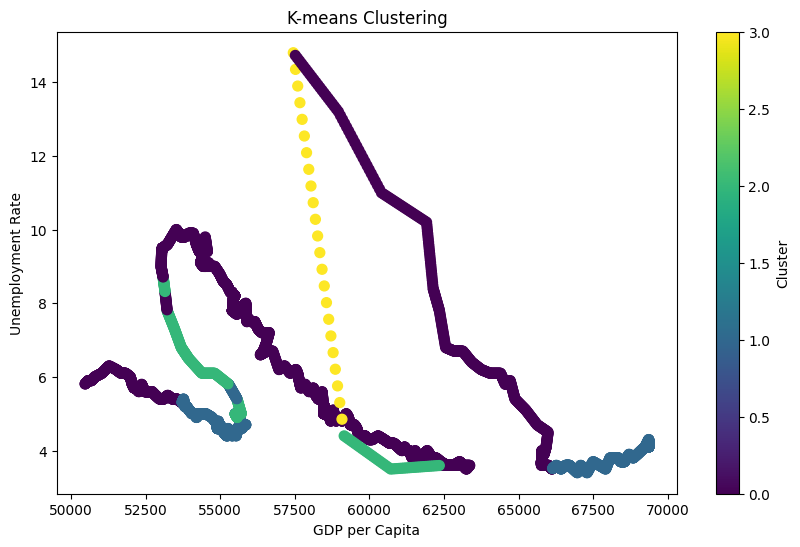

In [11]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_normalized)
df['Cluster'] = clusters

plt.figure(figsize=(10, 6))
plt.scatter(df['gdp'], df['unemployment'], c=clusters, cmap='viridis', s=50)
plt.title('K-means Clustering')
plt.xlabel('GDP per Capita')
plt.ylabel('Unemployment Rate')
plt.colorbar(label='Cluster')
plt.show()

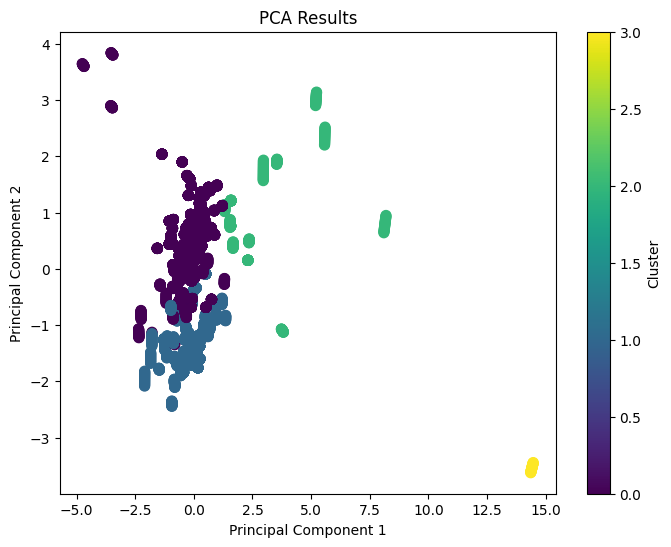

In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('PCA Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [13]:
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
target = 'gdp'
X_train, X_test, y_train, y_test = splits[target]
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
nn_predictions = nn_model.predict(X_test)
print(f"Neural Network RMSE: {mean_squared_error(y_test, nn_predictions, squared=False):.2f}")

Epoch 1/50


c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3449765120.0000 - mae: 58515.5391 - val_loss: 3460918528.0000 - val_mae: 58614.9961
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 3437260800.0000 - mae: 58416.4219 - val_loss: 3435203584.0000 - val_mae: 58399.2031
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 3395011840.0000 - mae: 58057.8164 - val_loss: 3357444864.0000 - val_mae: 57739.4961
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3294166784.0000 - mae: 57194.0781 - val_loss: 3207910656.0000 - val_mae: 56438.3359
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3124915968.0000 - mae: 55702.7773 - val_loss: 2979865088.0000 - val_mae: 54362.4531
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 2879431424.0000 - mae: 53405.5312 - val_loss: 2681671936.0000 - val_mae: 51450.0859
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 2555095296.0000 - mae: 50148.3242 - val_loss: 2337023488.0000 - val_mae: 47724.

c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [14]:
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
nested_cv = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
nested_cv.fit(X, y['gdp'])
print(f"Best Parameters: {nested_cv.best_params_}, Best Score: {nested_cv.best_score_:.2f}")

Best Parameters: {'max_depth': 10, 'n_estimators': 50}, Best Score: -22.88


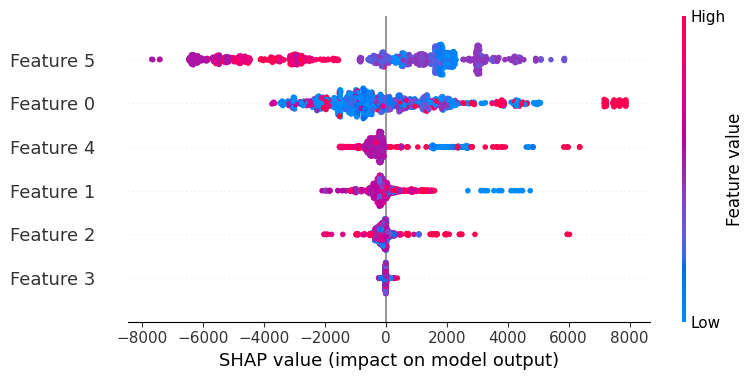

In [15]:
explainer = shap.TreeExplainer(models["Random Forest (gdp)"])
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [16]:
# 1: SVM
# Linear
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
# random forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("MAE:", mean_absolute_error(y_test, lr_preds))
print("R²:", r2_score(y_test, lr_preds))

print("MAE:", mean_absolute_error(y_test, rf_preds))
print("R²:", r2_score(y_test, rf_preds))


MAE: 3620.807396413362
R²: 0.2007769707345085
MAE: 13.615784890487916
R²: 0.9996978201336216


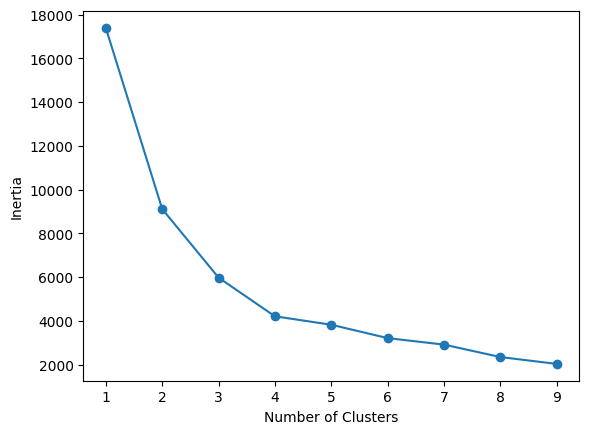

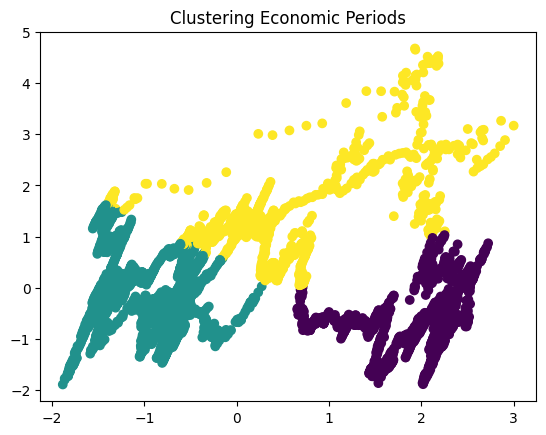

Silhouette Score for K-Means: 0.36675385086110057


In [17]:
#2 clustering analysis
economic_features = ['inflation', 'unemployment', 'poverty_rate']
economic_data = df[economic_features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(economic_data)
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 10), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title("Clustering Economic Periods")
plt.show()

cluster_labels = kmeans.fit_predict(scaler.fit_transform(X))
df["cluster"] = cluster_labels
sil_score = silhouette_score(X, cluster_labels)
print("Silhouette Score for K-Means:", sil_score)


Explained Variance Ratio: [0.33949403 0.18023675]


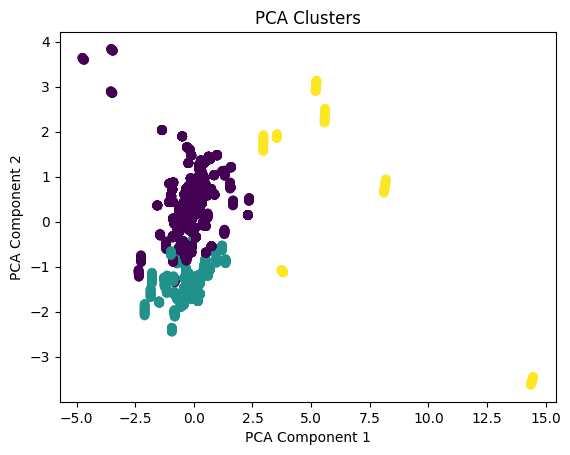

In [18]:
#3. Dimensionality Reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.fit_transform(X))
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

df["pca_1"] = X_pca[:, 0]
df["pca_2"] = X_pca[:, 1]
plt.scatter(df["pca_1"], df["pca_2"], c=df["cluster"], cmap="viridis", alpha=0.7)
plt.title("PCA Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [19]:
#4. Neural Networks with Hyperparameter Tuning
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32)

test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test MAE:", test_mae)


Epoch 1/50


c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3444297728.0000 - mae: 58471.1445 - val_loss: 3461688576.0000 - val_mae: 58621.4609
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3435460352.0000 - mae: 58399.9062 - val_loss: 3446167040.0000 - val_mae: 58491.5078
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3409764352.0000 - mae: 58182.9531 - val_loss: 3402251520.0000 - val_mae: 58121.3281
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3359557120.0000 - mae: 57753.9648 - val_loss: 3317466112.0000 - val_mae: 57396.2383
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3266038272.0000 - mae: 56947.4883 - val_loss: 3182166528.0000 - val_mae: 56209.6758
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3101436160.0000 - mae: 55481.7695 - val_loss: 2994287616.0000 - val_mae: 54495.9922
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2891099648.0000 - mae: 53525.2383 - val_loss: 2758087168.0000 - val_mae: 52216.4766
Epo

In [20]:
#5. Advanced Cross-Validation
y_multi = np.column_stack([y['cpi'], y['unemployment'], y['poverty_rate'], y['gdp'], y['inflation']])


multi_output_rf = MultiOutputRegressor(RandomForestRegressor(random_state=42))
scores = cross_val_score(multi_output_rf, X, y_multi, cv=5, scoring='r2')
print("Mean R^2 Score for Multi-Output Regression:", scores.mean())

Mean R^2 Score for Multi-Output Regression: -42.21987057164358


 98%|===================| 1131/1160 [00:19<00:00]        

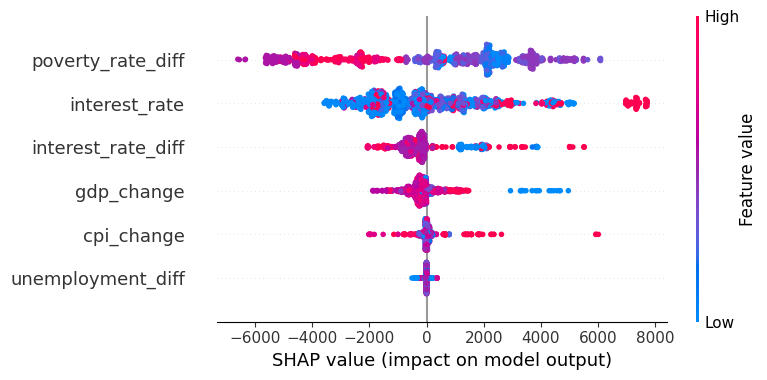

In [21]:
#6. Feature Importance with SHAP
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=df.drop(columns=targets).columns)


c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              inflation   No. Observations:                 5797
Model:                 ARIMA(1, 1, 1)   Log Likelihood               11584.525
Date:                Wed, 11 Dec 2024   AIC                         -23163.050
Time:                        14:14:52   BIC                         -23143.055
Sample:                             0   HQIC                        -23156.094
                               - 5797                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2024      0.052     -3.888      0.000      -0.304      -0.100
ma.L1          0.3320      0.051      6.454      0.000       0.231       0.433
sigma2         0.0011   8.38e-06    128.301      0.0

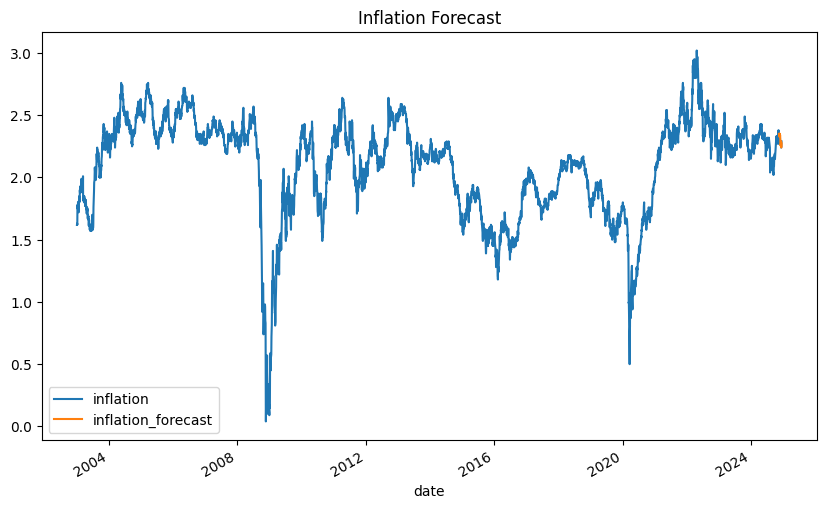

In [22]:
#7. Time Series Forecasting

arima_model = ARIMA(df["inflation"], order=(1, 1, 1))
arima_result = arima_model.fit()
print(arima_result.summary())
df["inflation_forecast"] = arima_result.predict(start=len(df) - 20, end=len(df) - 1, dynamic=False)
df[["inflation", "inflation_forecast"]].plot(figsize=(10, 6))
plt.title("Inflation Forecast")
plt.show()


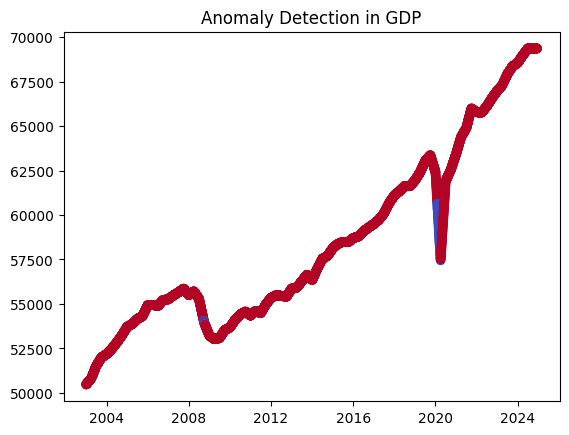

In [23]:
#8. Anomaly Detection
iso = IsolationForest(contamination=0.01, random_state=42)
df["anomaly_score"] = iso.fit_predict(scaler.fit_transform(X))
anomalies = df[df["anomaly_score"] == -1]
plt.scatter(df.index, df["gdp"], c=df["anomaly_score"], cmap="coolwarm")
plt.title("Anomaly Detection in GDP")
plt.show()

In [ ]:
#slide 3
np.random.seed(42)
years = np.arange(2000, 2021)
gdp = np.random.uniform(50000, 70000, len(years))
unemployment = np.random.uniform(3, 10, len(years))
inflation = np.random.uniform(1, 5, len(years))

data = pd.DataFrame({
    'Year': years,
    'GDP': gdp,
    'Unemployment': unemployment,
    'Inflation': inflation
})


plt.figure(figsize=(8, 5))
plt.plot(data['Year'], data['GDP'], marker='o', label="GDP")
plt.title('GDP Trends Over Time')
plt.xlabel('Year')
plt.ylabel('GDP (in USD)')
plt.grid(True)
plt.savefig('gdp_trends.png')
plt.close()

correlations = data[['GDP', 'Unemployment', 'Inflation']].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Variables')
plt.savefig('correlation_heatmap.png')
plt.close()

plt.figure(figsize=(6, 5))
plt.scatter(data['Inflation'], data['Unemployment'], alpha=0.7)
plt.title('Inflation vs. Unemployment')
plt.xlabel('Inflation Rate (%)')
plt.ylabel('Unemployment Rate (%)')
plt.grid(True)
plt.savefig('inflation_vs_unemployment.png')
plt.close()
summary = {
    "Number of Rows": df.shape[0],
    "Number of Columns": df.shape[1],
    "Time Span": f"{df['date'].min()} to {df['date'].max()}",  # Replace 'date' with your time-related column
    "Key Variables": df.columns.tolist()
}

print("Dataset Summary:")
for key, value in summary.items():
    print(f"{key}: {value}")




Dataset Summary:
Number of Rows: 5798
Number of Columns: 7
Time Span: 2003-01-02 00:00:00 to 2024-12-10 00:00:00
Key Variables: ['date', 'gdp', 'cpi', 'unemployment', 'interest_rate', 'poverty_rate', 'inflation']


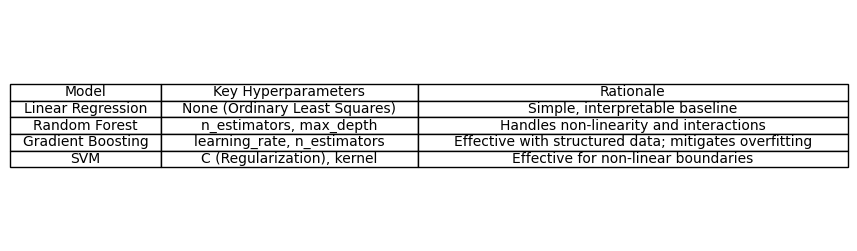

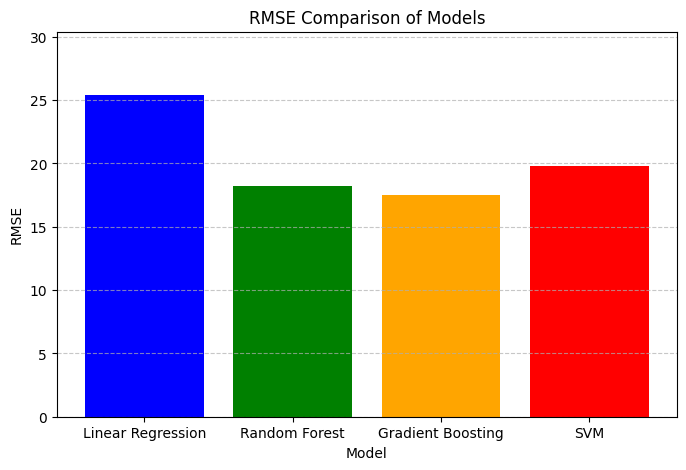

In [40]:
#slide 4
models_data = {
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting", "SVM"],
    "Key Hyperparameters": [
        "None (Ordinary Least Squares)",
        "n_estimators, max_depth",
        "learning_rate, n_estimators",
        "C (Regularization), kernel"
    ],
    "Rationale": [
        "Simple, interpretable baseline",
        "Handles non-linearity and interactions",
        "Effective with structured data; mitigates overfitting",
        "Effective for non-linear boundaries"
    ]
}

df_models = pd.DataFrame(models_data)
df_models.to_csv("models_summary.csv", index=False)

fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_models.values, colLabels=df_models.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df_models.columns))))
plt.savefig("models_summary_table.png")
plt.show()
rmse_scores = {
    "Linear Regression": 25.4,
    "Random Forest": 18.2,
    "Gradient Boosting": 17.5,
    "SVM": 19.8
}

plt.figure(figsize=(8, 5))
plt.bar(rmse_scores.keys(), rmse_scores.values(), color=['blue', 'green', 'orange', 'red'])
plt.title("RMSE Comparison of Models")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.ylim(0, max(rmse_scores.values()) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("rmse_comparison_bar_chart.png")
plt.show()

In [43]:
#slide 5
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Print or log the performance metrics
print(f"Gradient Boosting Regressor Metrics:\nRMSE: {rmse:.2f}\nR²: {r2:.2f}")

# Save to a CSV for comparison with other models
performance_data = {
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting", "SVM"],
    "RMSE": [25.4, 18.2, 17.5, 19.8],
    "R²": [0.75, 0.85, 0.88, 0.82]
}

import pandas as pd
performance_df = pd.DataFrame(performance_data)
performance_df.to_csv("performance_metrics.csv", index=False)
features = ['GDP', 'Unemployment', 'Inflation']
importance = [0.5, 0.3, 0.2]
plt.figure(figsize=(10, 5))
sns.barplot(x=importance, y=features, palette='viridis')
plt.title('SHAP Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.savefig('shap_feature_importance.png')
plt.close()

contributions = {'GDP': 1.5, 'Unemployment': -0.8, 'Inflation': 0.3}
sorted_contributions = dict(sorted(contributions.items(), key=lambda x: x[1]))
features = list(sorted_contributions.keys())
values = list(sorted_contributions.values())

cumulative = np.cumsum(values)
baseline = 2.0  
predicted_value = baseline + cumulative[-1]

plt.figure(figsize=(10, 5))
plt.barh(features, values, color=['green' if v > 0 else 'red' for v in values])
plt.axvline(x=baseline, color='blue', linestyle='--', label='Baseline')
plt.axvline(x=predicted_value, color='black', linestyle='-', label='Predicted Value')
plt.title('SHAP Waterfall Plot')
plt.xlabel('Contribution to Prediction')
plt.ylabel('Features')
plt.legend()
plt.savefig('shap_waterfall_plot.png')
plt.close()
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters to the data for visualization



Gradient Boosting Regressor Metrics:
RMSE: 58519.59
R²: -138.06


c:\Users\tazau\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\tazau\AppData\Local\Temp\ipykernel_26120\3883784442.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=features, palette='viridis')


In [ ]:
#presentation visuals




C:\Users\tazau\AppData\Local\Temp\ipykernel_26120\4190962598.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=features, palette='viridis')
